In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

In [3]:
from google.colab import drive
drive.mount('/content/drive')
file_path = "/content/drive/My Drive/classification_of_reviews/lamoda_reviews.csv"

data = pd.read_csv(file_path)

Mounted at /content/drive


In [12]:
data['Rating'] = data['Rating'].apply(lambda x: x*2)

In [13]:
data['Sentiment'] = data['Rating'].apply(lambda x: 1 if x >= 7 else 0)

In [25]:
data = data.dropna()

In [26]:
data

,Name,Description,Review,Rating,Sentiment
0,Кроссовки NIKE AIR MAX SC,Кроссовки выполнены из натуральной кожи с текс...,"Отличные кроссовки, очень лёгкие, на ножке акк...",10,1
1,Кроссовки NIKE AIR MAX SC,Кроссовки выполнены из натуральной кожи с текс...,"Красивые, стильные, удобные.",10,1
2,Кроссовки NIKE AIR MAX SC,Кроссовки выполнены из натуральной кожи с текс...,Все хорошо. Идет в размер,10,1
3,Кроссовки NIKE AIR MAX SC,Кроссовки выполнены из натуральной кожи с текс...,"Удобные и красивые, но вся грязь собирается на...",8,1
4,Кроссовки NIKE AIR MAX SC,Кроссовки выполнены из натуральной кожи с текс...,Удобные пока не носоли.,10,1
...,...,...,...,...,...
112460,Сланцы ULTRATOUCH,Сланцы выполнены из полиуретана. Специальный р...,"Легкие, удобные",10,1
112461,Сланцы ULTRATOUCH,Сланцы выполнены из полиуретана. Специальный р...,"В размер,удобные,взяла на море.Запах конечно ж...",6,0
112462,Сланцы ULTRATOUCH,Сланцы выполнены из полиуретана. Специальный р...,Шлёпанцы огонь ! Брала месяц назад на море в т...,10,1
112463,Сланцы ULTRATOUCH,Сланцы выполнены из полиуретана. Специальный р...,Шлепки хороши!,10,1


Отзыв будет считаться положительным, если его оценка неменьше 7-ми.

Для начала обучим логистическую регрессию на «грязных» данных, но сразу будем использовать tf-idf.

## 1. Logreg без очистки

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data[['Review']],
                                                    data['Sentiment'],
                                                    stratify=data['Sentiment'],
                                                    test_size=0.25,
                                                    random_state=42)

In [28]:
X_train.shape, X_test.shape

((84348, 1), (28116, 1))

In [29]:
raw_logreg = Pipeline([
    ('tf', TfidfVectorizer()),
    ('clf', LogisticRegression(random_state=42))
])

In [30]:
raw_logreg.fit(X_train['Review'], y_train)

Pipeline(steps=[('tf', TfidfVectorizer()),
                ('clf', LogisticRegression(random_state=42))])

In [31]:
pred = raw_logreg.predict(X_test['Review'])
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.73      0.27      0.39      1468
           1       0.96      0.99      0.98     26648

    accuracy                           0.96     28116
   macro avg       0.85      0.63      0.68     28116
weighted avg       0.95      0.96      0.95     28116



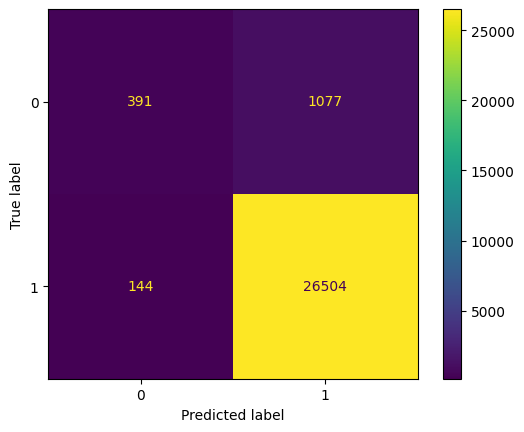

In [32]:
_ = ConfusionMatrixDisplay.from_estimator(raw_logreg, X_test['Review'], y_test)

## 2. Logreg с предобработкой (стеммер)

In [33]:
data_clean = data.copy()

In [34]:
def count_russian_chars(s: str) -> int:
    return len(re.findall(r'[а-яА-Я]', s))

data_clean['Russian chars'] = data_clean['Review'].apply(count_russian_chars)

In [35]:
data_clean_russian = data_clean[data_clean['Russian chars'] > 0]
data_clean_russian = data_clean_russian.reset_index(drop=True)

In [36]:
nltk.download('punkt')
nltk.download('punkt_tab')

stemmer = SnowballStemmer("russian")

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    words = word_tokenize(text, language="russian")
    words = [stemmer.stem(word) for word in words]
    return " ".join(words)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [37]:
data_clean_russian['Review'] = data_clean_russian['Review'].apply(lambda x: preprocess_text(str(x)))

In [38]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_clean_russian[['Review']],
                                                    data_clean_russian['Sentiment'],
                                                    stratify=data_clean_russian['Sentiment'],
                                                    test_size=0.25,
                                                    random_state=42)

In [39]:
pipeline = Pipeline([
    ('tf', TfidfVectorizer()),
    ('clf', LogisticRegression(random_state=42))
])

In [40]:
pipeline.fit(X_train['Review'], y_train)

Pipeline(steps=[('tf', TfidfVectorizer()),
                ('clf', LogisticRegression(random_state=42))])

In [41]:
pred = pipeline.predict(X_test['Review'])
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.76      0.33      0.46      1459
           1       0.96      0.99      0.98     24736

    accuracy                           0.96     26195
   macro avg       0.86      0.66      0.72     26195
weighted avg       0.95      0.96      0.95     26195



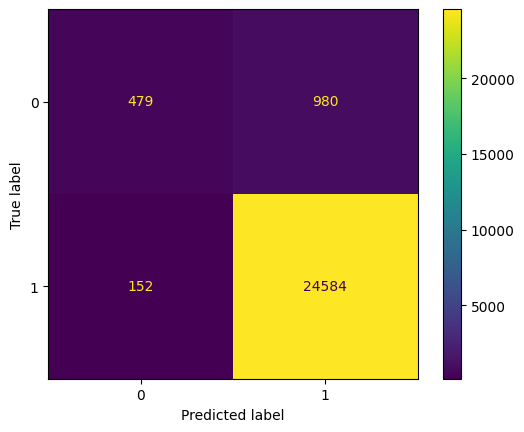

In [42]:
_ = ConfusionMatrixDisplay.from_estimator(pipeline, X_test['Review'], y_test)

## 3. Logreg с предобработкой (стеммер) и подбором гиперпараметров (для tf-idf тоже)

In [43]:
pipeline = Pipeline([
    ('tf', TfidfVectorizer()),
    ('clf', LogisticRegression(random_state=42))
])

param_grid = {
    'tf__ngram_range': [(1, 1), (1, 2)], # Важно посмотреть хотя бы на биграммах тоже
    'tf__max_features': [500, 1000, None],
    'clf__C': [0.1, 1, 10],
}

grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='precision', n_jobs=-1)

In [44]:
grid_search.fit(X_train['Review'], y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tf', TfidfVectorizer()),
                                       ('clf',
                                        LogisticRegression(random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.1, 1, 10],
                         'tf__max_features': [500, 1000, None],
                         'tf__ngram_range': [(1, 1), (1, 2)]},
             scoring='precision')

In [45]:
print("Best parameters:", grid_search.best_params_)
best_clf = grid_search.best_estimator_

Best parameters: {'clf__C': 10, 'tf__max_features': None, 'tf__ngram_range': (1, 2)}


In [46]:
pred = best_clf.predict(X_test['Review'])
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.75      0.54      0.63      1459
           1       0.97      0.99      0.98     24736

    accuracy                           0.96     26195
   macro avg       0.86      0.76      0.80     26195
weighted avg       0.96      0.96      0.96     26195



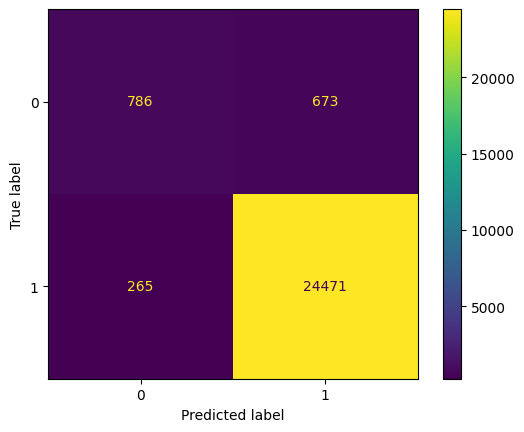

In [47]:
_ = ConfusionMatrixDisplay.from_estimator(best_clf, X_test['Review'], y_test)

## 4. Logreg с предобработкой (стеммер + стопслова)

In [48]:
data_clean = data.copy()

In [49]:
def count_russian_chars(s: str) -> int:
    return len(re.findall(r'[а-яА-Я]', s))

data_clean['Russian chars'] = data_clean['Review'].apply(count_russian_chars)

In [50]:
data_clean_russian = data_clean[data_clean['Russian chars'] > 0]
data_clean_russian = data_clean_russian.reset_index(drop=True)

In [51]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

stemmer = SnowballStemmer("russian")
stop_words = set(stopwords.words("russian"))

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    words = word_tokenize(text, language="russian")
    words = [stemmer.stem(word) for word in words if word not in stop_words]
    return " ".join(words)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [52]:
data_clean_russian['Review'] = data_clean_russian['Review'].apply(lambda x: preprocess_text(str(x)))

In [53]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_clean_russian[['Review']],
                                                    data_clean_russian['Sentiment'],
                                                    stratify=data_clean_russian['Sentiment'],
                                                    test_size=0.25,
                                                    random_state=42)

In [54]:
pipeline_2 = Pipeline([
    ('tf', TfidfVectorizer()),
    ('clf', LogisticRegression(random_state=42))
])

In [55]:
pipeline_2.fit(X_train['Review'], y_train)

Pipeline(steps=[('tf', TfidfVectorizer()),
                ('clf', LogisticRegression(random_state=42))])

In [56]:
pred = pipeline_2.predict(X_test['Review'])
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.76      0.28      0.41      1459
           1       0.96      0.99      0.98     24736

    accuracy                           0.95     26195
   macro avg       0.86      0.64      0.69     26195
weighted avg       0.95      0.95      0.95     26195



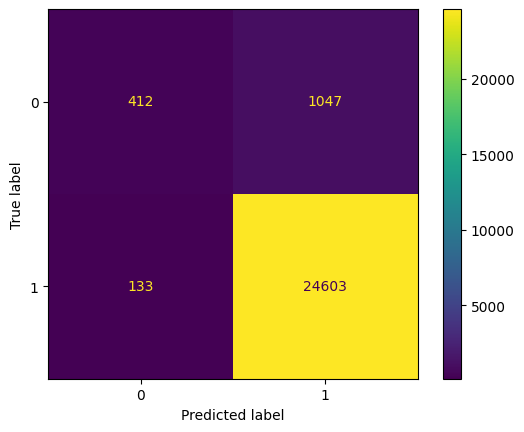

In [57]:
_ = ConfusionMatrixDisplay.from_estimator(pipeline_2, X_test['Review'], y_test)

## 5. Logreg с предобработкой (стеммер + стопслова) и подбором гиперпараметров (для tf-idf тоже)

In [58]:
pipeline = Pipeline([
    ('tf', TfidfVectorizer()),
    ('clf', LogisticRegression(random_state=42))
])

param_grid = {
    'tf__ngram_range': [(1, 1), (1, 2)], # Важно посмотреть хотя бы на биграммах тоже
    'tf__max_features': [500, 1000, None],
    'clf__C': [0.1, 1, 10],
}

grid_search_2 = GridSearchCV(pipeline, param_grid, cv=3, scoring='precision', n_jobs=-1)

In [59]:
grid_search_2.fit(X_train['Review'], y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tf', TfidfVectorizer()),
                                       ('clf',
                                        LogisticRegression(random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.1, 1, 10],
                         'tf__max_features': [500, 1000, None],
                         'tf__ngram_range': [(1, 1), (1, 2)]},
             scoring='precision')

In [60]:
print("Best parameters:", grid_search_2.best_params_)
best_clf_2 = grid_search_2.best_estimator_

Best parameters: {'clf__C': 10, 'tf__max_features': None, 'tf__ngram_range': (1, 2)}


In [61]:
pred = best_clf_2.predict(X_test['Review'])
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.74      0.46      0.57      1459
           1       0.97      0.99      0.98     24736

    accuracy                           0.96     26195
   macro avg       0.85      0.73      0.77     26195
weighted avg       0.96      0.96      0.96     26195



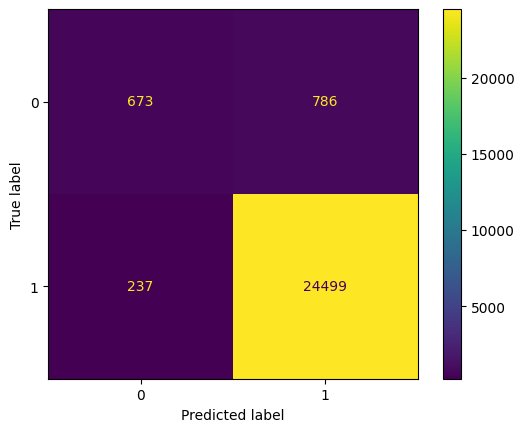

In [62]:
_ = ConfusionMatrixDisplay.from_estimator(best_clf_2, X_test['Review'], y_test)

# Вывод

## 1. Logreg без тюнинга
Базовая модель логистической регрессии без дополнительной предобработки текста и подбора гиперпараметров.
### Результаты:
*   Класс 0 (негативные): Precision=0.73, Recall=0.27, F1=0.39
*   Класс 1 (позитивные): Precision=0.96, Recall=0.99, F1=0.98
*   Accuracy: 0.96

Модель демонстрирует отличные результаты для позитивных отзывов, но крайне низкий recall для негативных (0.27), что означает пропуск 73% негативных отзывов.

## 2. Logreg с предобработкой (стеммер)
Добавлена предобработка текста с использованием стемминга.
### Результаты:
*   Класс 0 (негативные): Precision=0.76 (+0.03), Recall=0.33 (+0.06), F1=0.46 (+0.07)
*   Класс 1 (позитивные): Precision=0.96 (=), Recall=0.99 (=), F1=0.98 (=)
*   Accuracy: 0.96 (=)

Стемминг улучшил все метрики для негативных отзывов, особенно F1-score (+7%). Precision класса 0 вырос на 3%.

## 3. Logreg с предобработкой (стеммер) и подбором гиперпараметров (для tf-idf тоже)
Добавлен подбор гиперпараметров для модели и TF-IDF.
### Результаты:
*   Класс 0 (негативные): Precision=0.75 (-0.01), Recall=0.54 (+0.21), F1=0.63 (+0.17)
*   Класс 1 (позитивные): Precision=0.97 (+0.01), Recall=0.99 (=), F1=0.98 (=)
*   Accuracy: 0.96 (=)

Тюнинг гиперпараметров дал значительный прирост recall для негативных отзывов (+21% относительно базовой модели). F1-score для класса 0 улучшился на 24%.

## 4. Logreg с предобработкой (стеммер + стопслова)
Добавлено удаление стоп-слов к предобработке.
### Результаты:
*   Класс 0 (негативные): Precision=0.76 (=), Recall=0.28 (-0.05), F1=0.41 (-0.05)
*   Класс 1 (позитивные): Precision=0.96 (=), Recall=0.99 (=), F1=0.98 (=)
*   Accuracy: 0.95 (-0.01)

Удаление стоп-слов ухудшило recall для негативных отзывов на 5% по сравнению с чистым стеммингом.

## 5. Logreg с предобработкой (стеммер + стопслова) и подбором гиперпараметров (для tf-idf тоже)
Комбинация стемминга, удаления стоп-слов и подбора гиперпараметров.
### Результаты:
*   Класс 0 (негативные): Precision=0.74 (-0.02), Recall=0.46 (+0.18), F1=0.57 (+0.11)
*   Класс 1 (позитивные): Precision=0.97 (+0.01), Recall=0.99 (=), F1=0.98 (=)
*   Accuracy: 0.96 (+0.01)

Хотя тюнинг улучшил метрики по сравнению с версией без него, эта конфигурация уступает чистому стеммингу с тюнингом (Эксперимент 3).

## Итог
### Лучшая конфигурация
Эксперимент 3 (стемминг + подбор гиперпараметров) показал наилучшие результаты:
*   Максимальный F1-score для негативных отзывов (0.63)
*   Наибольший recall для класса 0 (0.54) - в 2 раза выше базовой модели
*   Сохранение высоких метрик для класса 1
*   Стабильная accuracy (0.96)

### Ключевые выводы:
1. Подбор гиперпараметров дает наиболее значимый прирост качества
2. Удаление стоп-слов не улучшает качество классификации
3. Стемминг оказывает положительное влияние
4. Мало отрицательных отзывов